In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Approximate Max-Cut using a Divide-and-Conquer Implementation of QAOA
## Lab 3 Recursive Divide-and-Conquer QAOA
## 3.1 Overview
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

In [ ]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q set up.
# Run this portion of the notebook in a CPU runtime
# Uncomment the line below and execute the cell to install cuda-q
# !pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/qaoa-for-max-cut/images ./images

In [ ]:
# Execute this cell to watch an introduction to this lab.
from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-3-Part-1.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

In the [previous lab](2_One-level-divide-and-conquer-QAOA.ipynb), our example graph was small enough that when divided into subgraphs, there were few subgraphs. Furthermore,  each subgraph was sufficiently small that we could apply QAOA to approximate the max cuts of the subgraphs. In this lab, we'll consider much bigger graphs which have large subgraph partitions, both in terms the size of the subgraphs and the number of subgraphs.  When the subgraphs are prohibitively large to find a max cut approximation with QAOA, we'll recursively apply the divide-and-conquer algorithm to those subgraphs.  Also, if the number of subgraphs in a partition is so large that the QAOA application during the merger stage of the algorithm cannot be carried out, we can recursively apply a divide-and-conquer QAOA to the merger graph as well. Finally, we'll demonstrate a parallel implementation of the algorithm and discuss several options for improving its accuracy.

### 3.1.1 Outline of the lab

This lab is structured similarly to [Labs 1](1_Overview-Max-Cut-with-QAOA.ipynb) and [2](2_One-level-divide-and-conquer-QAOA.ipynb). We will be translating the code developed in Labs 1 and 2 into functions for recursive implementation.

* **3.2 Divide**
    * Problem definition and classical approximation
    * Define a function to carry out the divide stage of the algorithm recursively
* **3.3 Conquer**
    * Define a function to carry out the conquer stage of the algorithm recursively
* **3.4 Merge**
    * Define a function to carry out the merger stage of the algorithm recursively
    * Combine all the parts together to find the max cut of `sampleGraph3`
* **3.5 Enabling Distributed Quantum Computing**
    * Run the recursive algorithm in parallel using MPI
* **3.6 Further directions for experimentation**
    * Summarize several features of the divide-and-conquer QAOA that could be modified for improved performance

### 3.1.2 Learning objectives

The learning objectives of this tutorial are:
* Implement a recursive divide-and-conquer QAOA for Max Cut using CUDA Quantum
* Select from different target devices to execute quantum circuits
* Adapt the CUDA Quantum code to run in parallel through MPI
* Experiment with different layer counts and seeds to recognize the effect of increased layers and initial parameter choices in QAOA
* Identify several of the design choices available for implementing QAOA


In [ ]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q set up.
# Run this portion of the notebook in a CPU runtime
# Uncomment the line below and execute the cell to install cuda-q
# !pip install cudaq

In [ ]:
# Necessary packages
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [ ]:
# Identifying and setting target
targets = cudaq.get_targets()
#for target in targets:
#    print(target)
cudaq.set_target("qpp-cpu")
target = cudaq.get_target()

### 3.1.3 Reusable code from Labs 1 and 2

The code blocks in this section were copied over from [Labs 1](1_Overview-Max-Cut-with-QAOA.ipynb) and [2](2_One-level-divide-and-conquer-QAOA.ipynb) and will be reused in this lab.  As you execute these cells, take a moment to read through them to recognize their purpose and logic.

In [ ]:
# Define a function to generate the Hamiltonian for a max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int]):
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges

    Parameters
    ----------
    sources: List[int]
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,

    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        hamiltonian += 0.5*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))

    return hamiltonian

# Problem Kernel

@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable


    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# Mixer Kernel
@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable

    """
    rx(2.0*beta, qubit_0)


# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters (the alphas and betas in the circuit diagrams depicted above)
@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized


    """
    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)

    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j],thetas[i+layer_count])

def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph
    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    # Specify the optimizer and its initial parameters.
    optimizer = cudaq.optimizers.COBYLA()
    np.random.seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

In [ ]:
# These function from Lab 2 are used to identify the subgraph
# that contains a given vertex, and identify the vertices of the parent graph
# that lie on the border of the subgraphs in the subgraph dictionary

def subgraph_of_vertex(graph_dictionary, vertex):
    """
    A function that takes as input a subgraph partition (in the form of a graph dictionary) and a vertex.
    The function should return the key associated with the subgraph that contains the given vertex.

    Parameters
    ----------
    graph_dictionary: dict of networkX.Graph with str as keys
    v : int
        v is a name for a vertex
    Returns
    -------
    str
        the key associated with the subgraph that contains the given vertex.
    """
    # in case a vertex does not appear in the graph_dictionary, return the empty string
    location = ''

    for key in graph_dictionary:
        if vertex in graph_dictionary[key].nodes():
            location = key
    return location

def border(G, subgraph_dictionary):
    """Build a graph made up of border vertices from the subgraph partition

    Parameters
    ----------
    G: networkX.Graph
        Graph whose max cut we want to find
    subgraph_dictionary: dict of networkX graph with str as keys
        Each graph in the dictionary should be a subgraph of G

    Returns
    -------
    networkX.Graph
        Subgraph of G made up of only the edges connecting subgraphs in the subgraph dictionary
    """
    borderGraph = nx.Graph()
    for u,v in G.edges():
        border = True
        for key in subgraph_dictionary:
            SubG = subgraph_dictionary[key]
            edges = list(nx.edges(SubG))
            if (u,v) in edges:
                border = False
        if border==True:
            borderGraph.add_edge(u,v)

    return borderGraph

In [ ]:
# Returns the cut value of G based on the coloring of the nodes of G

def cutvalue(G):
    """Returns the cut value of G based on the coloring of the nodes of G

    Parameters
    ----------
    G: networkX.Graph
        Graph with binary value colors assigned to the vertices

    Returns
    -------
    int
        cut value of the graph determined by the vertex colors
    """
    cut = 0
    for u, v in G.edges():
        if G.nodes[u]['color'] != G.nodes[v]['color']:
            cut+=1
    return cut

## 3.2 Divide
### 3.2.1 Defining a larger example graph

In [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb) we experimented with a graph of 30 vertices. Let's ramp this up and start with a graph of 100 vertices!

We'll consider a randomly generated graph with a little more structure than the previous lab. The graph type is called the Newman Watts Strogatz network model. After you've completed the lab with this example, feel free to edit the parameters and uncomment/comment portions of the code below to test out other graphs.

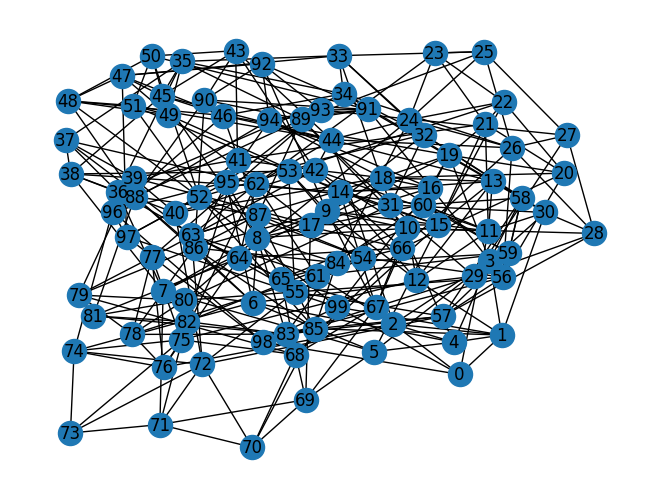

In [ ]:
# Newman Watts Strogatz network model
n = 100 # number of numdes
k = 4 # each node joined to k nearest neighbors
p =0.8 # probability of adding a new edge
seed = 1234
sampleGraph3=nx.newman_watts_strogatz_graph(n, k, p, seed=seed)


# Random d-regular graphs used in the paper arxiv:2205.11762
# d from 3, 9 inclusive
# number of vertices from from 60 to 80
# taking d=6 and n =100, works well
# d = 6
# n =100
# seed = 1234
#sampleGraph3=nx.random_regular_graph(d,n,seed=seed)


#random graph from lab 2
#n = 30  # number of nodes
#m = 70  # number of edges
#seed= 20160  # seed random number generators for reproducibility
# Use seed for reproducibility
#sampleGraph3= nx.gnm_random_graph(n, m, seed=seed)


# Plot example graph for which we will be trying to compute the max cut
nx.draw(sampleGraph3, with_labels=True)
plt.show()


Let's approximate the max cut for this graph classically.  This will take a little longer than the classical approximation of max cut for the smaller graph in [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb), and as you'll see there is a much larger variation in approximation results.

In [ ]:
number_of_approx =10
randomlist = np.random.choice(3000,number_of_approx)


minapprox = nx.algorithms.approximation.one_exchange(sampleGraph3, initial_cut=None, seed=int(randomlist[0]))[0]
maxapprox = minapprox
sum_of_approximations = 0
for i in range(number_of_approx):
   seed = int(randomlist[i])
   ith_approximation = nx.algorithms.approximation.one_exchange(sampleGraph3, initial_cut=None, seed=seed)[0]
   if ith_approximation < minapprox:
      minapprox = ith_approximation
   if ith_approximation > maxapprox:
      maxapprox = ith_approximation
   sum_of_approximations += nx.algorithms.approximation.one_exchange(sampleGraph3, initial_cut=None, seed=seed)[0]

average_approx = sum_of_approximations/number_of_approx

print('A few runs of the greedy modularity maximization algorithm gives an average approximate Max Cut value of',average_approx)
print('with approximations ranging from',minapprox,'to',maxapprox)

A few runs of the greedy modularity maximization algorithm gives an average approximate Max Cut value of 247.1
with approximations ranging from 243 to 253


 The code for the subgraph partitioning from [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb) is copied below.  We'll need to adapt this code for recursion.  But first, to appreciate the need for a recursive algorithm, let's use this code to partition the `sampleGraph3` graph into smaller subgraphs to get a sense of the scale of the graph.

In [ ]:
# Function from Lab 2 to return a dictionary of subgraphs of the input graph
# using the greedy modularity maximization algorithm

def Lab2SubgraphPartition(G,n):
    """Divide the graph up into at most n subgraphs

    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide
    n : int
        n is the maximum number of subgraphs in the partition

    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    # n is the maximum number of subgraphs in the partition
    greedy_partition = community.greedy_modularity_communities(G, weight=None, resolution=1.1, cutoff=1, best_n=n)
    number_of_subgraphs = len(greedy_partition)

    graph_dictionary = {}
    graph_names=[]
    for i in range(number_of_subgraphs):
        name='G'+str(i)
        graph_names.append(name)

    for i in range(number_of_subgraphs):
        nodelist = sorted(list(greedy_partition[i]))
        graph_dictionary[graph_names[i]] = nx.subgraph(G, nodelist)

    return(graph_dictionary)

In [ ]:
num_subgraphs = min(12, sampleGraph3.number_of_nodes()) # maximum number of subgraphs for the partition
subgraph_dictionary = Lab2SubgraphPartition(sampleGraph3,num_subgraphs)

# Print the subgraphs and their information
print('The parent graph is subdivided into',len(subgraph_dictionary),'subgraphs.')
for key in subgraph_dictionary:
    print('Graph',key,'has',len(nx.nodes(subgraph_dictionary[key])),'vertices.')
    print('Graph',key,'has',len
          (nx.edges(subgraph_dictionary[key])),'edges.')


The parent graph is subdivided into 6 subgraphs.
Graph G0 has 22 vertices.
Graph G0 has 50 edges.
Graph G1 has 19 vertices.
Graph G1 has 42 edges.
Graph G2 has 18 vertices.
Graph G2 has 37 edges.
Graph G3 has 17 vertices.
Graph G3 has 36 edges.
Graph G4 has 13 vertices.
Graph G4 has 24 edges.
Graph G5 has 11 vertices.
Graph G5 has 20 edges.


The graph `G0` may be too large for a standard implementation of QAOA, especially if many layers of the QAOA kernel are used or if the algorithm is executed on a CPU. Even larger and denser graphs will lead to partitions that are just unmanageable for even the most powerful machines. Therefore, we will recursively call the divide-and-conquer QAOA algorithm to find the max cut solution.  In fact, in the interest of time, we will apply the divide stage of the algorithm to any subgraph that has more than 14 vertices. To keep track of the original graph, its subgraphs, their subgraphs, etc. we will need to edit the subgraph partitioning function from [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb) and adapt a new subgraph naming scheme. In the new naming scheme, `Global:0` will be the first subgraph in the partitioning of `sampleGraph3`.  If `Global:0` was large and was further subdivided, the the name `Global:0:1` will represent the second subgraph of the subgraph partitioning of `Global:0`. The naming scheme continues to follow this pattern. This new naming scheme is added to the `subgraph_partition` function in the code block below.

In [ ]:
def subgraphpartition(G,n, name, globalGraph):
    # G is a graph to be partitioned

    """Divide the graph up into at most n subgraphs

    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide which lives inside of or is equatl to globalGraph
    n : int
        n is the maximum number of subgraphs in the partition
    name : str
        prefix for the graphs (in our case we'll use 'Global')
    globalGraph: networkX.Graph
        original problem graph

    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    greedy_partition = community.greedy_modularity_communities(G, weight=None, resolution=1.1, cutoff=1, best_n=n)
    number_of_subgraphs = len(greedy_partition)

    graph_dictionary = {}
    graph_names=[]
    for i in range(number_of_subgraphs):
        subgraphname=name+':'+str(i)
        graph_names.append(subgraphname)

    for i in range(number_of_subgraphs):
        nodelist = sorted(list(greedy_partition[i]))
        graph_dictionary[graph_names[i]] = nx.subgraph(globalGraph, nodelist)

    return(graph_dictionary)

Edit the three `FIX_ME` lines in the code block below to call `subgraphpartition` recursively.  We'll assume that we can handle QAOA instances of 14 qubits.  Therefore any subgraph of more than 14 vertices will get subdivided.

In [ ]:
# EXERCISE
num_qubits = 14
n = 12 # maximum number of subgraphs in a subgraph partitioning
def recursive_partition(G,name, global_graph):
    """Divide the graph up into subgraphs of at most num_qubits vertices recursively

    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide which is a subgraph of global_graph
    name : str
        prefix for the graphs (in our case we'll use 'Global')
    global_graph : networkX.Graph
        parent graph

    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    if nx.number_of_nodes(G)<FIX_ME:                             # Edit this line
        print('Graph',name,'has',len(nx.nodes(G)),'vertices.')
    else:
        max_num_subgraphs = min(n, nx.number_of_nodes(G))
        new_subgraphs = FIX_ME(G, max_num_subgraphs, name, global_graph)   # Edit this line
        for key in new_subgraphs:
            FIX_ME(new_subgraphs[key],key, global_graph)        # Edit this line

# Apply the partitioning function to the sampleGraph3
recursive_partition(sampleGraph3, 'Global', sampleGraph3)


In [ ]:
# SOLUTION
num_qubits = 14
n = 12 # maximum number of subgraphs in a subgraph partitioning
def recursive_partition(G,name, global_graph):
    """Divide the graph up into subgraphs of at most num_qubits vertices recursively

    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide which is a subgraph of global_graph
    name : str
        prefix for the graphs (in our case we'll use 'Global')
    global_graph : networkX.Graph
        parent graph

    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    if nx.number_of_nodes(G)<num_qubits+1:
        print('Graph',name,'has',len(nx.nodes(G)),'vertices.')
    else:
        max_num_subgraphs = min(n, nx.number_of_nodes(G))
        new_subgraphs = subgraphpartition(G, max_num_subgraphs, name, global_graph)
        for key in new_subgraphs:
            recursive_partition(new_subgraphs[key],key, global_graph)

# Apply the partitioning function to the sampleGraph3
recursive_partition(sampleGraph3, 'Global', sampleGraph3)

Graph Global:0:0 has 6 vertices.
Graph Global:0:1 has 6 vertices.
Graph Global:0:2 has 6 vertices.
Graph Global:0:3 has 4 vertices.
Graph Global:1:0 has 8 vertices.
Graph Global:1:1 has 6 vertices.
Graph Global:1:2 has 5 vertices.
Graph Global:2:0 has 6 vertices.
Graph Global:2:1 has 5 vertices.
Graph Global:2:2 has 5 vertices.
Graph Global:2:3 has 2 vertices.
Graph Global:3:0 has 7 vertices.
Graph Global:3:1 has 5 vertices.
Graph Global:3:2 has 5 vertices.
Graph Global:4 has 13 vertices.
Graph Global:5 has 11 vertices.


## 3.3 Conquer

As you experiment with subdividing other graphs, you might notice that the last few subgraphs may only contain 1 vertex and/or no edges.  The max cut for these subgraphs is trivial. It would be wasteful to run the QAOA subroutine on these subgraphs, and a Hamiltonian = 0 will cause problems with the optimizer loop.  Let's edit the QAOA code below to return a random assignment of 0s and 1s for graphs that contain only one vertex and/or no edges.  

**Exercise:** Edit the code below to return a random string of 0s and 1s, with the same length as the number of vertices of the graph.

In [ ]:
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """
    ### Edit code below to return a random string of 0s and 1s
    ### if G has only one vertex and/or no edges
    ### The string should have the same length as the number of
    ### vertices of G.
    if FIX_ME:




    ### Edit code above
    else:
        parameter_count: int = 2 * layer_count

        # Problem parameters
        nodes = sorted(list(nx.nodes(G)))
        qubit_src = []
        qubit_tgt = []
        for u, v in nx.edges(G):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            qubit_src.append(nodes.index(u))
            qubit_tgt.append(nodes.index(v))
        # The number of qubits we'll need is the same as the number of vertices in our graph
        qubit_count : int = len(nodes)
        # Each layer of the QAOA kernel contains 2 parameters
        parameter_count : int = 2*layer_count

        optimal_parameters = find_optimal_parameters(G, layer_count, seed)

        # Print the optimized parameters
        print("Optimal parameters = ", optimal_parameters)

        # Sample the circuit
        counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
        print('most_probable outcome = ',counts.most_probable())
        results = str(counts.most_probable())
    return results

In [ ]:
# SOLUTION
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """
    if nx.number_of_nodes(G) ==1 or nx.number_of_edges(G) ==0:
        # The first condition implies the second condition so we really don't need
        # to consider the case nx.number_of_nodes(G) ==1
        results = ''
        for u in list(nx.nodes(G)):
            np.random.seed(seed)
            random_assignment = str(np.random.randint(0, 1))
            results+=random_assignment

    else:
        parameter_count: int = 2 * layer_count

        # Problem parameters
        nodes = sorted(list(nx.nodes(G)))
        qubit_src = []
        qubit_tgt = []
        for u, v in nx.edges(G):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            qubit_src.append(nodes.index(u))
            qubit_tgt.append(nodes.index(v))
        # The number of qubits we'll need is the same as the number of vertices in our graph
        qubit_count : int = len(nodes)
        # Each layer of the QAOA kernel contains 2 parameters
        parameter_count : int = 2*layer_count

        optimal_parameters = find_optimal_parameters(G, layer_count, seed)

        # Print the optimized parameters
        print("Optimal parameters = ", optimal_parameters)

        # Sample the circuit
        counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
        print('most_probable outcome = ',counts.most_probable())
        results = str(counts.most_probable())
    return results

## 3.4 Merge

The functions below are based on code from [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb) that carry out the merger step of the divide-and-conquer QAOA. As you execute the code blocks, familiarize yourself with the function definitions.

In [ ]:

# Define the mergerGraph for a given border graph and subgraph
# partitioning. And color code the vertices
# according to the subgraph that the vertex represents
def createMergerGraph(border, subgraphs):
    """Build a graph containing a vertex for each subgraph
    and edges between vertices are added if there is an edge between
    the corresponding subgraphs

    Parameters
    ----------
    border : networkX.Graph
        Graph of connections between vertices in distinct subgraphs
    subgraphs : dict of networkX graph with str as keys
        The nodes of border should be a subset of the the graphs in the subgraphs dictionary

    Returns
    -------
    networkX.Graph
        Merger graph containing a vertex for each subgraph
        and edges between vertices are added if there is an edge between
        the corresponding subgraphs
    """
    M = nx.Graph()

    for u, v in border.edges():
        subgraph_id_for_u = subgraph_of_vertex(subgraphs, u)
        subgraph_id_for_v = subgraph_of_vertex(subgraphs, v)
        if subgraph_id_for_u != subgraph_id_for_v:
            M.add_edge(subgraph_id_for_u, subgraph_id_for_v)
    return M


# Compute the penalties for edges in the supplied mergerGraph
# for the subgraph partitioning of graph G
def merger_graph_penalties(mergerGraph, subgraph_dictionary, G):
    """Compute penalties for the edges in the mergerGraph and add them
    as edge attributes.

    Parameters
    ----------
    mergerGraph : networkX.Graph
        Graph of connections between vertices in distinct subgraphs of G
    subgraph_dictionary : dict of networkX graph with str as keys
        subgraphs of G that are represented as nodes in the mergerGraph
    G : networkX.Graph
        graph whose vertices has an attribute 'color'

    Returns
    -------
    networkX.Graph
        Merger graph containing penalties
    """
    nx.set_edge_attributes(mergerGraph, int(0), 'penalty')
    for i, j in mergerGraph.edges():
        penalty_ij = 0
        for u in nx.nodes(subgraph_dictionary[i]):
            for neighbor_u in nx.all_neighbors(G, u):
                if neighbor_u in nx.nodes(subgraph_dictionary[j]):
                    if G.nodes[u]['color'] != G.nodes[neighbor_u]['color']:
                        penalty_ij += 1
                    else:
                        penalty_ij += -1
        mergerGraph[i][j]['penalty'] = penalty_ij
    return mergerGraph


# Define the Hamiltonian for applying QAOA during the merger stage
# The variables s_i are defined so that s_i = 1 means we will not
# flip the subgraph Gi's colors and s_i = -1 means we will flip the colors of subgraph G_i
def mHamiltonian(merger_edge_src, merger_edge_tgt, penalty):
    """Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph

    Parameters
    ----------
    merger_edge_src: List[int]
        list of the source vertices of edges of a graph
    merger_edge_tgt: List[int]
        list of target vertices of edges of a graph
    penalty: List[int]
        list of penalty terms associated with the edge determined by the source and target vertex of the same index

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the optimal swap schedule for the subgraph partitioning encoded in the merger graph
    """
    mergerHamiltonian = 0

 # Add Hamiltonian terms for edges within a subgraph that contain a border element
    for i in range(len(merger_edge_src)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = merger_edge_src[i]
        qubitv = merger_edge_tgt[i]
        mergerHamiltonian+= -penalty[i]*(spin.z(qubitu))*(spin.z(qubitv))
    return mergerHamiltonian

In [ ]:
# Next we define some functions to keep track of the unaltered cuts
# (recorded as unaltered_colors) and the merged cuts (recorded as new_colors).
# The new_colors are derived from flipping the colors
# of all the nodes in a subgraph based on the flip_colors variable which
# captures the solution to the merger QAOA problem.

def unaltered_colors(G, graph_dictionary, max_cuts):
    """Adds colors to each vertex, v, of G based on the color of v in the subgraph containing v which is
    read from the max_cuts dictionary

    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    subgraph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    max_cuts : dict of str
        dictionary of node colors for subgraphs in the subgraph_dictionary

    Returns
    -------
    networkX.Graph, str
        returns G with colored nodes
    """
    subgraphColors={}


    for key in graph_dictionary:
        SubG = graph_dictionary[key]
        sorted_subgraph_nodes = sorted(list(nx.nodes(SubG)))
        for v in sorted_subgraph_nodes:
            G.nodes[v]['color']=max_cuts[key][sorted_subgraph_nodes.index(v)]
    # returns the input graph G with a coloring of the nodes based on the unaltered merger
    # of the max cut solutions of the subgraphs in the graph_dictionary
    return G

def new_colors(graph_dictionary, G, mergerGraph, flip_colors):
    """For each subgraph in the flip_colors list, changes the color of all the vertices in that subgraph
    and records this information in the color attribute of G

    Parameters
    ----------
    graph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    G : networkX.Graph
        Graph with vertex color attributes
    mergerGraph: networkX.Graph
        Graph whose vertices represent subgraphs in the graph_dictionary
    flip_colors : dict of str
        dictionary of binary strings for subgraphs in the subgraph_dictionary
        key:0 indicates the node colors remain fixed in subgraph called key
        key:1 indicates the node colors should be flipped in subgraph key

    Returns
    -------
    networkX.Graph, str
        returns G with the revised vertex colors
    """
    flipGraphColors={}
    mergerNodes = sorted(list(nx.nodes(mergerGraph)))
    for u in mergerNodes:
        indexu = mergerNodes.index(u)
        flipGraphColors[u]=int(flip_colors[indexu])

    for key in graph_dictionary:
        if flipGraphColors[key]==1:
            for u in graph_dictionary[key].nodes():
                G.nodes[u]['color'] = str(1 - int(G.nodes[u]['color']))

    revised_colors = ''
    for u in sorted(G.nodes()):
        revised_colors += str(G.nodes[u]['color'])

    return G, revised_colors


In [ ]:
# A function to carry out QAOA during the merger stage of the
# divide-and-conquer QAOA algorithm for graph G, its subgraphs (graph_dictionary)
# and merger_graph

def merging(G, graph_dictionary, merger_graph):
    """
    Using QAOA, identify which subgraphs should be in the swap schedule (e.g. which subgraphs will require
    flipping of the colors when merging the subgraph solutions into a solution of the graph G

    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    graph_dictionary : dict of networkX graph with str as keys
        subgraphs of G
    mergerGraph : networkX.Graph
        Graph whose vertices represent subgraphs in the graph_dictionary

    Returns
    -------
    str
        returns string of 0s and 1s indicating which subgraphs should have their colors swapped
    """

    merger_graph_with_penalties = merger_graph_penalties(merger_graph,graph_dictionary, G)
    # In the event that the merger penalties are not trivial, run QAOA, else don't flip any graph colors
    if (True in (merger_graph_with_penalties[u][v]['penalty'] != 0 for u, v in nx.edges(merger_graph_with_penalties))):

        penalty = []
        merger_edge_src = []
        merger_edge_tgt = []
        merger_nodes = sorted(list(merger_graph_with_penalties.nodes()))
        for u, v in nx.edges(merger_graph_with_penalties):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            merger_edge_src.append(merger_nodes.index(u))
            merger_edge_tgt.append(merger_nodes.index(v))
            penalty.append(merger_graph_with_penalties[u][v]['penalty'])

        merger_Hamiltonian = mHamiltonian(merger_edge_src, merger_edge_tgt, penalty)

        # Run QAOA on the merger subgraph to identify which subgraphs
        # if any should change colors
        layer_count_merger = 2 # set arbitrarily
        parameter_count_merger: int = 2 * layer_count_merger
        nodes_merger = sorted(list(nx.nodes(merger_graph)))
        merger_edge_src = []
        merger_edge_tgt = []
        for u, v in nx.edges(merger_graph_with_penalties):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            merger_edge_src.append(nodes_merger.index(u))
            merger_edge_tgt.append(nodes_merger.index(v))
        # The number of qubits we'll need is the same as the number of vertices in our graph
        qubit_count_merger : int = len(nodes_merger)

        # Specify the optimizer and its initial parameters. Make it repeatable.
        cudaq.set_random_seed(12345)
        optimizer_merger = cudaq.optimizers.COBYLA()
        np.random.seed(4321)
        optimizer_merger.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count_merger)
        optimizer_merger.max_iterations=150
        # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
        optimal_expectation, optimal_parameters = cudaq.vqe(
            kernel=kernel_qaoa,
            spin_operator=merger_Hamiltonian,
            argument_mapper=lambda parameter_vector: (qubit_count_merger, layer_count_merger, merger_edge_src, merger_edge_tgt, parameter_vector),
            optimizer=optimizer_merger,
            parameter_count=parameter_count_merger,
            shots = 10000)

        # Sample the circuit using the optimized parameters
        # Sample enough times to distinguish the most_probable outcome for
        # merger graphs with 12 vertices
        sample_number=30000
        counts = cudaq.sample(kernel_qaoa, qubit_count_merger, layer_count_merger, merger_edge_src, merger_edge_tgt, optimal_parameters, shots_count=10000)
        mergerResultsString = str(counts.most_probable())

    else:
        mergerResultsList = [0]*nx.number_of_nodes(merger_graph)
        mergerResultsString = ''.join(str(x) for x in mergerResultsList)
        print('Merging stage is trivial')
    return mergerResultsString


In this lab, we have capped our subgraph partitions to only have 11 subgraphs. This means that the merger graphs that we generate are all limited in size. Therefore, few qubits are needed for the QAOA circuits that are created during the `merging` phase of the algorithm. For much larger and denser graphs, we may find partitions that result in dozens of subgraphs whose solutions need to be merged together. For these cases, we can apply another divide-and-conquer protocol at the merger stage of the algorithm. We leave this as an optional bonus exercise.

## 3.4 Putting it all together

We now have all of the components necessary to define a function `subgraph_solution` that will carry out the divide-and-conquer QAOA recursively.

**Exercise:** Fill in the `FIX_ME`s with the functions from the list:


* `border`
* `createMergerGraph`
* `merging`
* `new_colors`
* `qaoa_for_graph`
* `subgraphpartition`
* `subgraph_solution`
* `unaltered_colors`



In [ ]:
# Exercise

def subgraph_solution(G, key, vertex_limit, subgraph_limit, layer_count, global_graph,seed ):
    """
    Recursively finds max cut approximations of the subgraphs of the global_graph
    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    key : str
        name of subgraph
    vertex_limit : int
        maximum size of graph to which QAOA will be applied directly
    subgraph_limit : int
        maximum size of the merger graphs, or maximum number of subgraphs in any subgraph decomposition
    layer_count : int
        number of layers in QAOA circuit for finding max cut solutions
    global_graph : networkX.Graph
        the parent graph
    seed : int
        random seed for reproducibility

    Returns
    -------
    str
        returns string of 0s and 1s representing colors of vertices of global_graph for the approx max cut solution
    """
    results ={}
    seed +=1
    # Find the max cut of G using QAOA, provided G is small enough
    if nx.number_of_nodes(G)<vertex_limit+1:
        print('Working on finding max cut approximations for ',key)

        result = FIX_ME(G, seed=seed, shots = 10000, layer_count=layer_count)
        results[key]=result
        # color the global graph's nodes according to the results
        nodes_of_G = sorted(list(G.nodes()))
        for u in G.nodes():
            global_graph.nodes[u]['color']=results[key][nodes_of_G.index(u)]
        return result
    else: # Recursively apply the algorithm in case G is too big
        # Divide the graph and identify the subgraph dictionary
        subgraph_limit =min(subgraph_limit, nx.number_of_nodes(G) )
        subgraph_dictionary = FIX_ME(G,subgraph_limit, str(key), global_graph)

        # Conquer: solve the subgraph problems recursively
        for skey in subgraph_dictionary:
            results[skey]=FIX_ME(subgraph_dictionary[skey], skey, vertex_limit, subgraph_limit, \
                                            layer_count, global_graph, seed )

        print('Found max cut approximations for ',list(subgraph_dictionary.keys()))


        # Color the nodes of G to indicate subgraph max cut solutions
        G = FIX_ME(G, subgraph_dictionary, results)
        unaltered_cut_value = cutvalue(G)
        print('prior to merging, the max cut value of',key,'is', unaltered_cut_value)

        # Merge: merge the results from the conquer stage
        print('Merging these solutions together for a solution to',key)
        # Define the border graph
        bordergraph = FIX_ME(G, subgraph_dictionary)
        # Define the merger graph
        merger_graph = FIX_ME(bordergraph, subgraph_dictionary)

        try:
            # Apply QAOA to the merger graph
            merger_results = FIX_ME(G, subgraph_dictionary, merger_graph)
        except:
            # In case QAOA for merger graph does not converge, don't flip any of the colors for the merger
            mergerResultsList = [0]*nx.number_of_nodes(merger_graph)
            merger_results = ''.join(str(x) for x in mergerResultsList)
            print('Merging subroutine opted out with an error for', key)

        # Color the nodes of G to indicate the merged subgraph solutions
        alteredG, new_color_list = FIX_ME(subgraph_dictionary, G, merger_graph, merger_results)
        newcut = cutvalue(alteredG)
        print('the merger algorithm produced a new coloring of',key,'with cut value,',newcut)

        return new_color_list





In [ ]:
# Solution

def subgraph_solution(G, key, vertex_limit, subgraph_limit, layer_count, global_graph,seed ):
    """
    Recursively finds max cut approximations of the subgraphs of the global_graph
    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    key : str
        name of subgraph
    vertex_limit : int
        maximum size of graph to which QAOA will be applied directly
    subgraph_limit : int
        maximum size of the merger graphs, or maximum number of subgraphs in any subgraph decomposition
    layer_count : int
        number of layers in QAOA circuit for finding max cut solutions
    global_graph : networkX.Graph
        the parent graph
    seed : int
        random seed for reproducibility

    Returns
    -------
    str
        returns string of 0s and 1s representing colors of vertices of global_graph for the approx max cut solution
    """
    results ={}
    seed +=1
    # Find the max cut of G using QAOA, provided G is small enough
    if nx.number_of_nodes(G)<vertex_limit+1:
        print('Working on finding max cut approximations for ',key)

        result =qaoa_for_graph(G, seed=seed, shots = 10000, layer_count=layer_count)
        results[key]=result
        # color the global graph's nodes according to the results
        nodes_of_G = sorted(list(G.nodes()))
        for u in G.nodes():
            global_graph.nodes[u]['color']=results[key][nodes_of_G.index(u)]
        return result
    else: # Recursively apply the algorithm in case G is too big
        # Divide the graph and identify the subgraph dictionary
        subgraph_limit =min(subgraph_limit, nx.number_of_nodes(G) )
        subgraph_dictionary = subgraphpartition(G,subgraph_limit, str(key), global_graph)

        # Conquer: solve the subgraph problems recursively
        for skey in subgraph_dictionary:
            results[skey]=subgraph_solution(subgraph_dictionary[skey], skey, vertex_limit, subgraph_limit, \
                                            layer_count, global_graph, seed )

        print('Found max cut approximations for ',list(subgraph_dictionary.keys()))


        # Color the nodes of G to indicate subgraph max cut solutions
        G = unaltered_colors(G, subgraph_dictionary, results)
        unaltered_cut_value = cutvalue(G)
        print('prior to merging, the max cut value of',key,'is', unaltered_cut_value)

        # Merge: merge the results from the conquer stage
        print('Merging these solutions together for a solution to',key)
        # Define the border graph
        bordergraph = border(G, subgraph_dictionary)
        # Define the merger graph
        merger_graph = createMergerGraph(bordergraph, subgraph_dictionary)

        try:
            # Apply QAOA to the merger graph
            merger_results = merging(G, subgraph_dictionary, merger_graph)
        except:
            # In case QAOA for merger graph does not converge, don't flip any of the colors for the merger
            mergerResultsList = [0]*nx.number_of_nodes(merger_graph)
            merger_results = ''.join(str(x) for x in mergerResultsList)
            print('Merging subroutine opted out with an error for', key)

        # Color the nodes of G to indicate the merged subgraph solutions
        alteredG, new_color_list = new_colors(subgraph_dictionary, G, merger_graph, merger_results)
        newcut = cutvalue(alteredG)
        print('the merger algorithm produced a new coloring of',key,'with cut value,',newcut)

        return new_color_list



Now let's run the recursive algorithm on a `sampleGraph3`.  Execute the cell below to run the algorithm sequentially.  This might be a good time to stand up and stretch or grab a cup of coffee.  It may take a few minutes for the program to run on one GPU sequentially. We'll explore how to parallelize this routine in the next section.

In [ ]:
num_subgraphs=11 # limits the size of the merger graphs
num_qubits = 14 # max number of qubits allowed in a quantum circuit
layer_count =1 # Layer count for the QAOA max cut
seed = 101

subgraph_solution(sampleGraph3, 'Global', num_subgraphs, num_qubits, layer_count, sampleGraph3, seed)

Working on finding max cut approximations for  Global:0:0
Optimal parameters =  [-2.85564571541018, -0.32425349445141555]
most_probable outcome =  110010
Working on finding max cut approximations for  Global:0:1
Optimal parameters =  [-2.884267580068141, -0.3057534524232721]
most_probable outcome =  000110
Working on finding max cut approximations for  Global:0:2
Optimal parameters =  [-1.3026899772514002, -1.8887376045196276]
most_probable outcome =  000101
Working on finding max cut approximations for  Global:0:3
Optimal parameters =  [-1.8163052146581165, -1.8535167728107051]
most_probable outcome =  1001
Found max cut approximations for  ['Global:0:0', 'Global:0:1', 'Global:0:2', 'Global:0:3']
prior to merging, the max cut value of Global:0 is 32
Merging these solutions together for a solution to Global:0
the merger algorithm produced a new coloring of Global:0 with cut value, 35
Working on finding max cut approximations for  Global:1:0
Optimal parameters =  [-2.8939498395065444, -

'1110010001110011111101101101000110010111100110011001111001011000011000110011010110011011100110011010'

This solution isn't as good as the classical approximations. In the remaining sections of this notebook, we'll suggest a few ways to improve the results.

##  3.5 Enabling Distributed Quantum Computing

There are many opportunities for parallelization of quantum circuits. In this section we'll run the QAOA kernels for each subgraph simultaneously on multiple GPU processes, and this can easily be adapted to run on multiple QPUs in the future.

In [ ]:
# Execute this cell to view a presentation about how to implement the recursive Divide-and-Conquer QAOA in parallel.
from IPython.display import HTML

video_url = "https://d36m44n9vdbmda.cloudfront.net/assets/x-ac-13-v1/max-cut-with-CUDA-Quantum-Lab-3-Part-2.mp4"

video_html = f"""
<video controls width="640" height="360">
    <source src="{video_url}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

display(HTML(video_html))

**Important** Before proceeding, you will need to switch to a runtime with access to a GPU.  If you do restart your kernel, make sure to reload the packages below.  If you are running on Google Colab and switch to a GPU runtime, you'll need to reinstall CUDA-Q by commenting out the indicated code.

In [ ]:
# Instructions for Google Colab. You can ignore this cell if you already have cuda-q set up and are working in a GPU runtime
# with all the necessary files
# Run this cell in a GPU runtime

#!pip install cudaq

#!wget -q -O Example-03.py https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/qaoa-for-max-cut/Example-03.py


In [ ]:
#@title Execute this cell to reload the necessary packages
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import sys

In [ ]:
#@title Execute this cell to install mpi4py if necessary
%pip install mpi4py



The max cut problem for the `sampleGraph3` took some time to solve sequentially.  Like we did in [Lab 2](2_One-level-divide-and-conquer-QAOA.ipynb), we can create a python script to run the recursive algorithm in parallel. One option is to distribute the top-level of the recursion (e.g. solutions to `Global:0`, `Global:1`, ...`Global:n`) to the GPU processes, and then merge those results back together on GPU process 0.  We've created the script for this and saved it as Example-03.py. If you have not yet already done so, download [Example-03.py](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/Example-03.py) and save it in your working directory.   Execute the cell below to find a max cut approximation of `sampleGraph3` using 4 GPU processes.

In [ ]:
# MPI call
print(sys.executable)
python_path = sys.executable
!mpiexec -np 4 --oversubscribe --allow-run-as-root {python_path} Example-03.py

Subgraph problems to be computed on each processor have been assigned
Processor 1 received {'Global:1': <networkx.classes.graph.Graph object at 0x7f90c3d39540>, 'Global:5': <networkx.classes.graph.Graph object at 0x7f8fb8720a30>} from processor 0
Processor 2 received {'Global:2': <networkx.classes.graph.Graph object at 0x7fa913091540>} from processor 0
Processor 3 received {'Global:3': <networkx.classes.graph.Graph object at 0x7faee05b9570>} from processor 0
Working on finding max cut approximations for  Global:2:0
Working on finding max cut approximations for  Global:3:0
Working on finding max cut approximations for  Global:0:0
Working on finding max cut approximations for  Global:1:0
Optimal parameters =  [0.28617781045515917, -1.8949633330759343]
most_probable outcome =  001101
Working on finding max cut approximations for  Global:0:1
Optimal parameters =  [1.310617651748266, -1.94050078740244]
most_probable outcome =  00011110
Working on finding max cut approximations for  Global:1

Notice how much more quickly the solution was found compared to the sequential implementation.  With this speed up, let's try to find even better approximations.  Try editing the `layer_count` for the QAOA max cut solution of the small graphs. You can find this on  `line 502: layer_count =1 # Layer count for the QAOA max cut` of the [Example-03.py](Example-03.py) file. Also, try out different seed values (`line 647: seed = 13 # Edit this seed for new initial parameters among other seed-dependent elements`). See how much our results change!  

Feel free to experiment with different sample graphs (`lines 706-730`) by commenting the code and changing the number of vertices and other graph variables.

Can you think of alternative methods of parallelizing the tasks in the divide-and-conquer QAOA?

## 3.6 Further Directions for Experimentation

There were many aspects of the QAOA algorithm that we held constant throughout this series of labs.  These include the choice of the graph partitioning routine, the initial superposition state in the QAOA kernel, the number of layers in the QAOA kernels, the initial parameters used in the optimization loop, and the optimizer selected for the optimization loop. In addition to making changes to these features, the QAOA kernel could be swapped out for an alternative variational ansatz, and the parallelization protocol could be optimized for the given problem.

* **Graph partitioning:** The graph partitioning can drastically affect the results of the algorithm.  There are many ways to subdivide a graph, and we encourage you to explore other possibilities. For example, the Louvain algorithm was used by [Yue et al.](https://arxiv.org/abs/2310.05062) and by [Guerreschi](https://arxiv.org/abs/2101.07813) for quantum divide-and-conquer approaches to the Max Cut problem. [Angel Rodriquez-Fernandez et al.](https://www.mdpi.com/2079-3197/8/3/75) analyzed five other clustering algorithms to improve the Goemans-Williamson classical approximation for Max-Cut, and these clustering algorithms could be experimented with here.  Looking at this from another point of view, the graph partitioning corresponds to circuit cutting.  There have been advances in identifying efficient cuts of a quantum circuit that result in faster circuit knitting (or as we referred to in these notebooks, the merger stage of the algorithm).  One example of this is [Adaptive Circuit Knitting](https://www.hpe.com/us/en/newsroom/blog-post/2025/03/scaling-quantum-computers-hewlett-packard-enterprise-and-nvidia-tackle-distributed-quantum-computation.html).  Read more about Adaptive Circuit Knitting in [section VIB of this survey paper](https://arxiv.org/pdf/2411.10406). 

* **Initial state:** In [Lab 1](1_Overview-Max-Cut-with-QAOA.ipynb), we initiated the QAOA kernel in an equal superposition state to represent all possible colorings of the vertices.  However, if we had some information about the structure of the graph, for instance an approximate solution from a classical relaxation of the problems, we could "warm start" the circuit with this information as in [Egger et al.](https://quantum-journal.org/papers/q-2021-06-17-479/) and [Tate et al.](https://quantum-journal.org/papers/q-2023-09-26-1121/). For this to work, the mixer Hamiltonian would also need to be adjusted.

* **Layer count:** We've already begun to experiment with the layer count. It is known that as the number of layers increase to infinity, the QAOA max cut approximations approach the max cut value of the graph ([Farhi and Goldstone](https://arxiv.org/pdf/1411.4028.pdf)).

* **Initial parameters:** As we saw in this lab, by varying the seed for generating the random initial parameters, we obtained quite different results.  Recent work points to several protocols for selecting better performing initial parameters (see for instance the work of [Sureshbabu et al.](https://arxiv.org/abs/2305.15201)).

* **Optimizer:** Throughout this series of labs we defaulted to the COBYLA optimizer for the optimizer loop in the  algorithm.  There are several other non-gradient and gradient-based optimizers available in CUDA-Q for you to try, and you can use your favorite sci.py optimizer as well.  See the full list of built-in CUDA-Q optimizers [here](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#cudaq.optimizers.optimizer).

* **QAOA kernel:** We used a standard QAOA kernel throughout this tutorial. There are several adaptations that could be made to the QAOA kernel. For example, one could replace the QAOA kernel with a similarly structured [multi-angle QAOA kernel](https://www.nature.com/articles/s41598-022-10555-8). The difference between the QAOA kernel and the multi-angle QAOA kernel is that instead of each layer having distinct parameters for the problem and the mixer kernels, each parameterized rotational gate would have its own distinct parameter. Another variation of the QAOA kernel is the ADAPT-QAOA algorithm which iteratively constructs the QAOA circuit, tailoring it for each problem [(Zhu et al.)](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.033029).  You can learn more about ADAPT-QAOA and how to implement it in CUDA-Q [here](https://nvidia.github.io/cuda-quantum/latest/applications/python/adapt_qaoa.html).  Taking this one step further, researchers have used ADAPT-QAOA circuits to train a QAOA-GPT model that generates compact quantum circuits for the max cut problem [(Tyagin et al.)](https://arxiv.org/pdf/2504.16350).

* **Alternatives to QAOA:** Other completely different variational circuit structures could replace the QAOA kernel in our algorithm. [Lee et al.](https://arxiv.org/abs/2105.01114) compared several options and concluded that noncommunativity and entanglement in the variational kernel were important for improving algorithm performance. There are also different options of encoding the graph structure into the quantum circuit.  For instance, instead of each vertex being represented by a single qubit, it is possible to encode a graph with half the number of qubits using techniques like [multi-basis encoding](https://arxiv.org/pdf/2106.13304).

* **Parallelization:** Finally, our choice of how to distribute the subgraph problems onto the GPU was quite arbitrary, and some GPU processes sat idle while others were finishing their tasks.  By first analyzing the subgraph partition, we might find a better distribution of tasks to the GPU to avoid down time.  Also, our parallelization protocol used one GPU to simulate multiple QPUs.  It is possible to assign multiple GPUs to simulate one QPU, which would be necessary for larger circuits.  To learn more about this option, check out the documentation on [the `remote-mqpu` platform](https://nvidia.github.io/cuda-quantum/0.6.0/using/cudaq/platform.html#remote-mqpu-platform).  Additionally, CUDA Quantum offers an `execution()` option for `observe` and asynchronous primitives `sample_async` and `observe_async`. You can read more about these functions [here](https://nvidia.github.io/cuda-quantum/0.6.0/examples/python/tutorials/multi_gpu_workflows.html).
  

## Next
Congratulations on solving max cut problems with the divide-and-conquer QAOA!  It's now time to see if you can apply what you have learned to a weighted graph in the [next notebook](4_Weighted-max-cut.ipynb).  Good luck!


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/images/nvidia-logo.png?raw=1)